# Predicting Device Failures

The dataset of this notebook consists of 12 features with 9 of the features being anonymized.  The goal of this notebook is to learn how to deal with imbalanced datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [2]:
device = pd.read_csv('failures.csv')

In [3]:
device.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
device.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524
std,0.029167,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [6]:
device['device'].nunique()

1168

An initial glance at the data shows me that:
    * There are only 1168 unique devices with over 100000 rows.
    * Attribute7 and attribute8 seem to be same.
    * There are no null values

# Exploratory Data Analysis

### Date

First, let's extract the year, month and day from the data column.  This way, we can get more information from the date.

In [7]:
device['date'] = pd.to_datetime(device['date'])

In [8]:
device['year'] = device['date'].map(lambda x: x.year)
device['month'] = device['date'].map(lambda x: x.month)
device['day'] = device['date'].map(lambda x: x.day)

I grab the number of times a certain device occurs within the dataset.

In [9]:
num_of_occur = dict(device.groupby('device')['date'].size())
device['number_of_occurences'] = device['device'].map(num_of_occur)

In [10]:
device.drop('date', axis=1, inplace=True)

### Failures

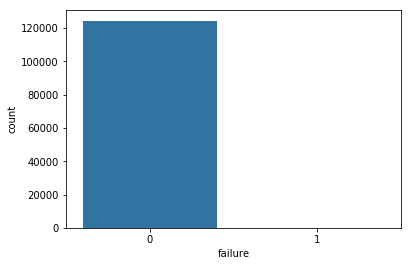

In [11]:
sns.countplot(device['failure'])

In [12]:
device['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

It can be seen that the label for this dataset is extremely imbalanced.  If one were to just get 0 (not a device failure) every single time, they would get over 99% accuracy.  Methods of balancing the dataset will need to be explored later.  We will be looking at **precision** and **recall** scores to judge the accuracy of dataset.

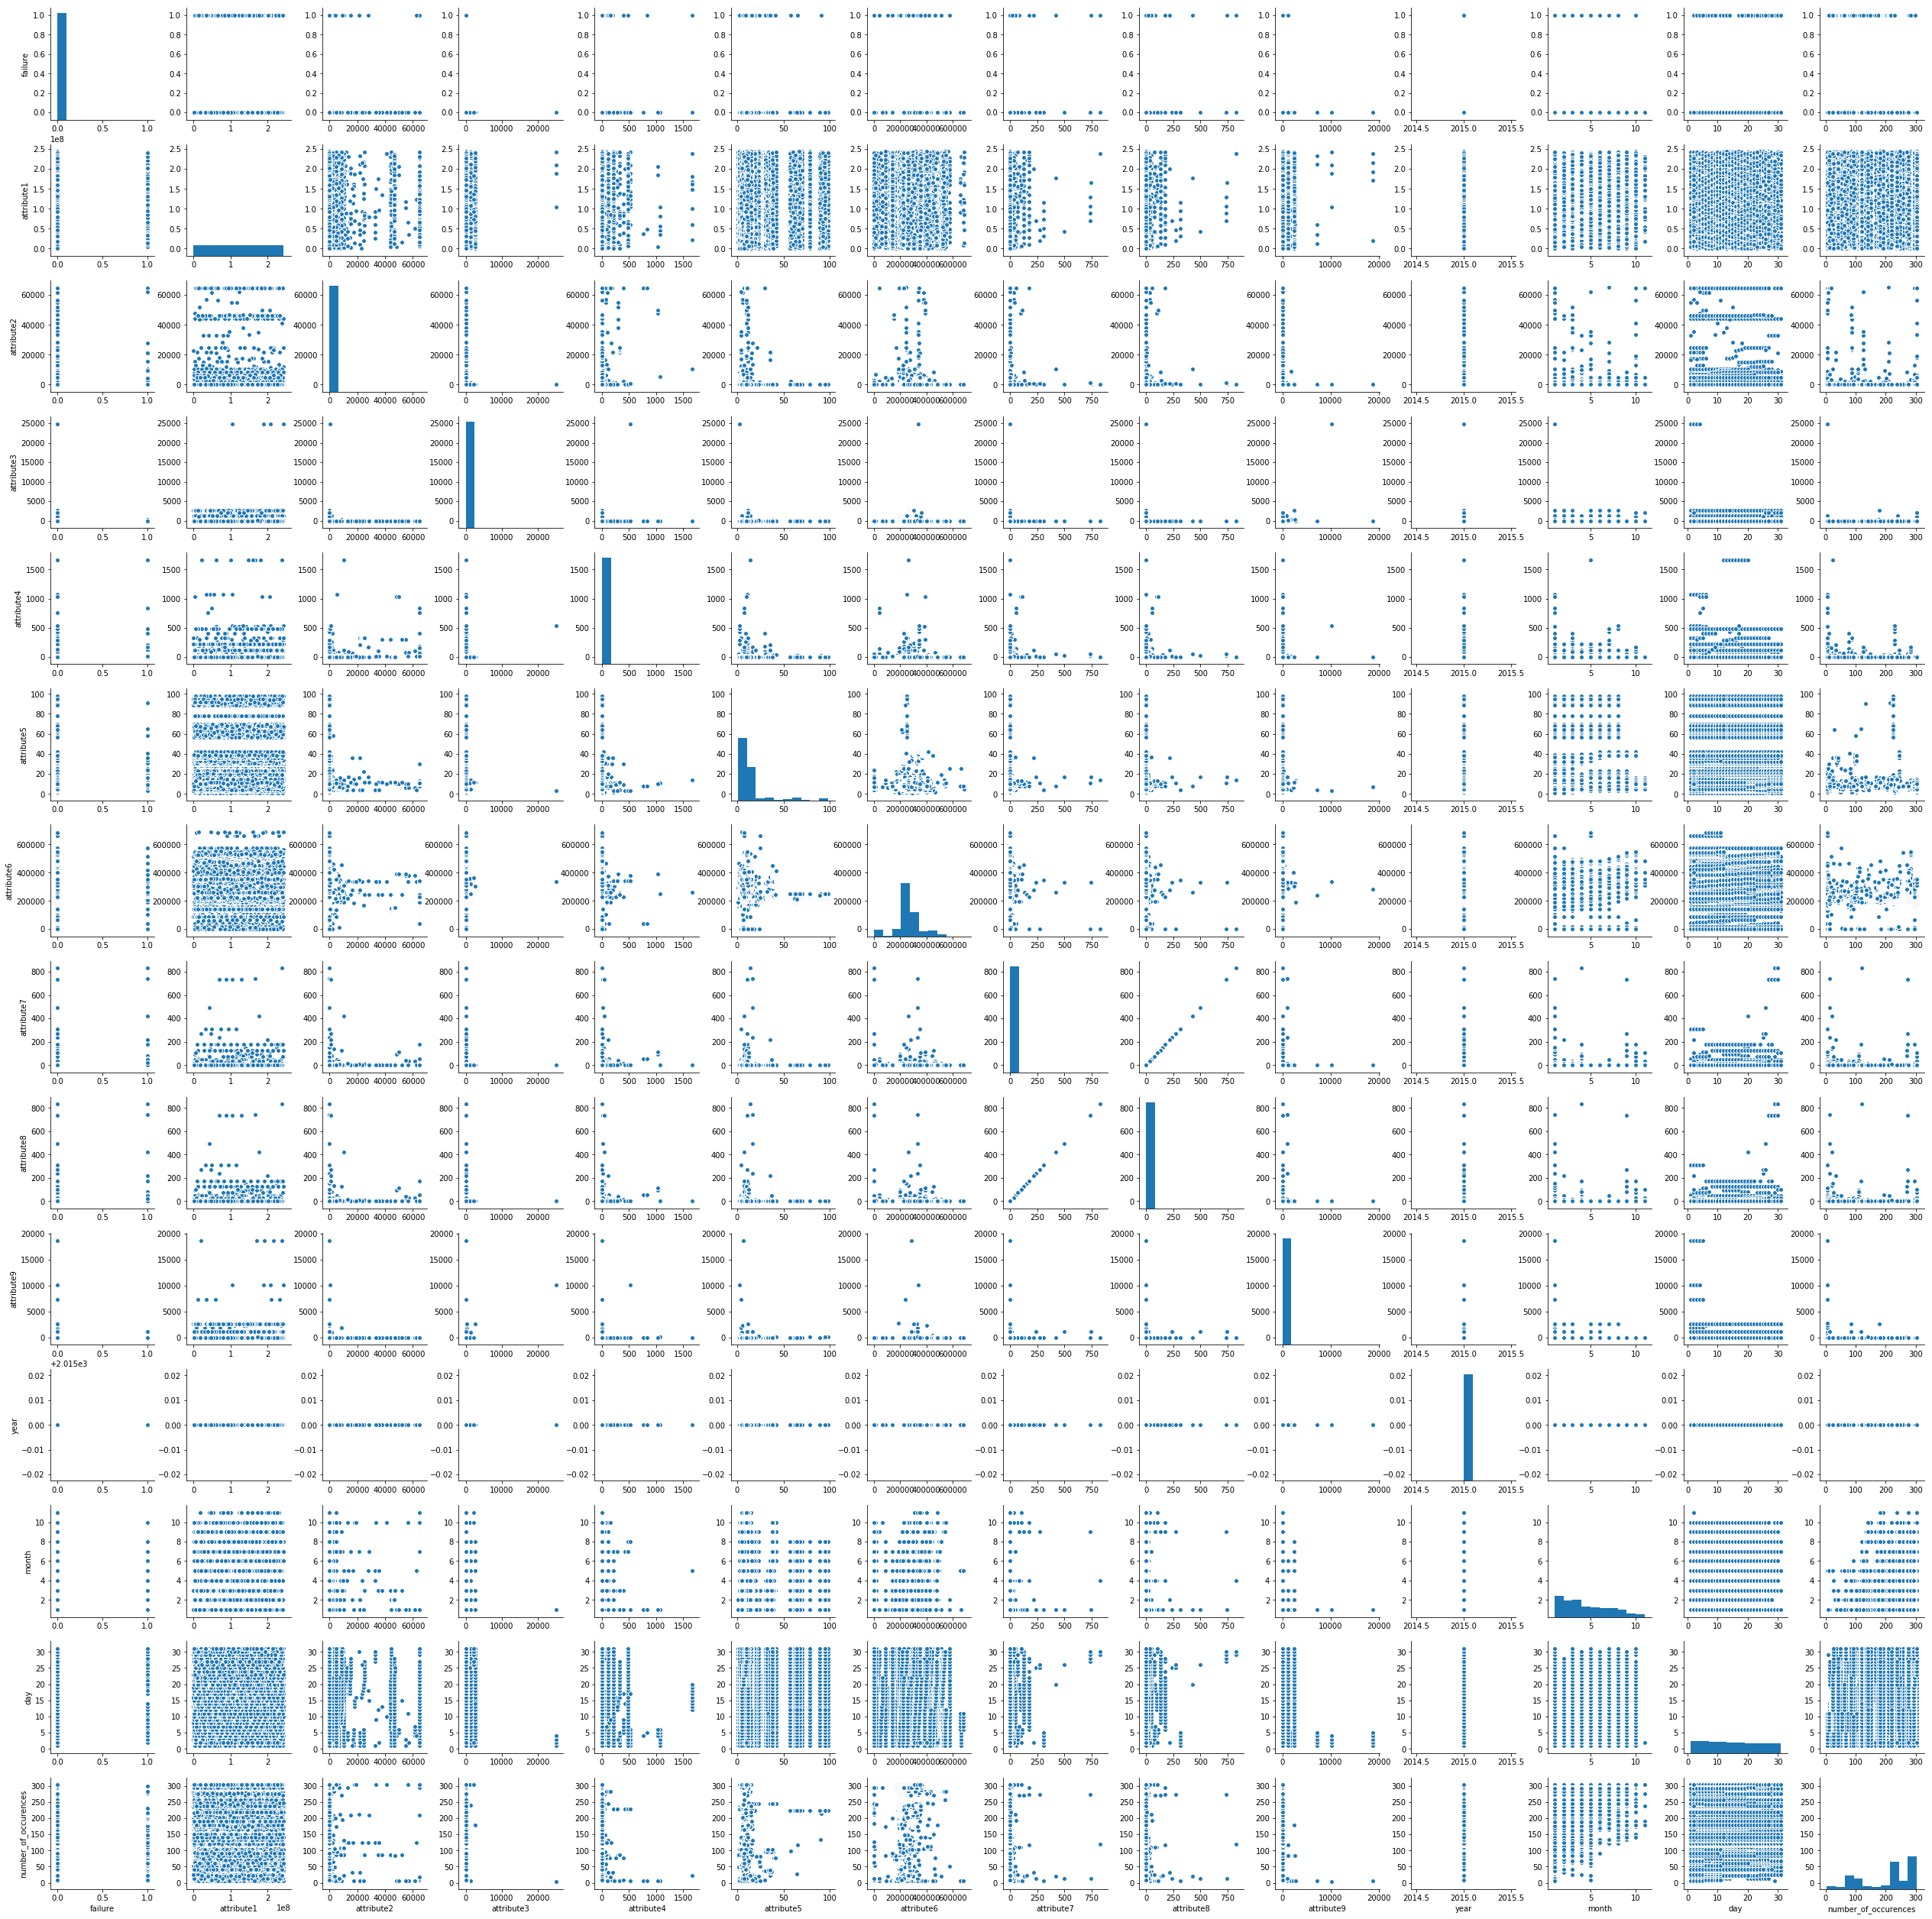

In [13]:
sns.pairplot(device)

It's difficult to see, but none of the attributes seem to be strongly correlated with one another (except attributes 7 and 8, which are perfectly linear).

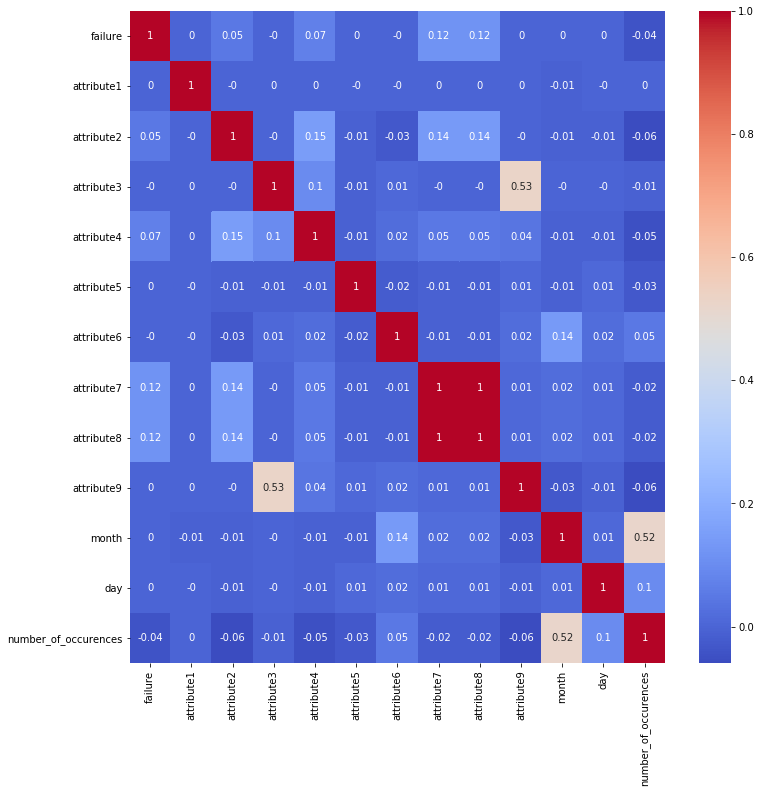

In [14]:
plt.figure(figsize=(12, 12))
sns.heatmap(device.drop('year', axis=1).corr().round(2), annot=True, cmap='coolwarm')

### Attribute 7 and 8

Since attribute 7 and 8 are the same feature, I'm going to assume that this is intentional.  I will remove one of the columns and multiply the other one by 2 to give it more weight.

In [15]:
device['attribute7'] = device['attribute7'].map(lambda x: x * 2)
device.drop('attribute8', axis=1, inplace=True)

In [16]:
device.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,year,month,day,number_of_occurences
0,S1F01085,0,215630672,56,0,52,6,407438,0,7,2015,1,1,6
1,S1F0166B,0,61370680,0,3,0,6,403174,0,0,2015,1,1,6
2,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,2015,1,1,48
3,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,2015,1,1,6
4,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,2015,1,1,223


## Feature Engineering

* Given that, it is impossible to have domain knowledge on the dataset because it is anonymized, I will have to rely on some basic feature engineering techniques to uncover more information about the data.

### Determining categorical and quantitative features

In [17]:
device.nunique()

device                    1168
failure                      2
attribute1              123878
attribute2                 558
attribute3                  47
attribute4                 115
attribute5                  60
attribute6               44838
attribute7                  28
attribute9                  65
year                         1
month                       11
day                         31
number_of_occurences       139
dtype: int64

Any attribute with greater than 500 unique values will be considered continuous and any other attribute will be considered categorical.  We can then create new features by taken the mean of the continous attributes.

In [18]:
device['attr1_mean_by_device'] = device['device'].map(dict(device.groupby('device')['attribute1'].mean()))
device['attr2_mean_by_device'] = device['device'].map(dict(device.groupby('device')['attribute2'].mean()))
device['attr6_mean_by_device'] = device['device'].map(dict(device.groupby('device')['attribute6'].mean()))

I can also create a feature based on the total days by converting the month to days.  I round the average length of a month to 30 days.

In [19]:
device['total_days'] = ((device['month'] - 1) * 30) + device['day']

I create a feature based on the difference between the last day the device was active and the first day.

In [20]:
device['difference_in_max_min_days'] = device['device'].map(dict(device.groupby('device')['total_days'].max() - device.groupby('device')['total_days'].min()))

I create a feature based on the rate of failure of devices by month.

In [21]:
device['failure_rate_by_month'] = device['month'].map(dict(device.groupby(['month'])['failure'].mean()))

I create interaction terms between all the continous variables with all the categorical variables.

In [22]:
# Interactions with attr1
device['attr1*attr3'] = device['attribute1'] * device['attribute3']
device['attr1*attr4'] = device['attribute1'] * device['attribute4']
device['attr1*attr5'] = device['attribute1'] * device['attribute5']
device['attr1*attr7'] = device['attribute1'] * device['attribute7']
device['attr1*attr9'] = device['attribute1'] * device['attribute9']

#Interactions with attr2
device['attr2*attr3'] = device['attribute2'] * device['attribute3']
device['attr2*attr4'] = device['attribute2'] * device['attribute4']
device['attr2*attr5'] = device['attribute2'] * device['attribute5']
device['attr2*attr7'] = device['attribute2'] * device['attribute7']
device['attr2*attr9'] = device['attribute2'] * device['attribute9']

# Interactions with attr6
device['attr6*attr3'] = device['attribute6'] * device['attribute3']
device['attr6*attr4'] = device['attribute6'] * device['attribute4']
device['attr6*attr5'] = device['attribute6'] * device['attribute5']
device['attr6*attr7'] = device['attribute6'] * device['attribute7']
device['attr6*attr9'] = device['attribute6'] * device['attribute9']

I divide the months into seasons.

In [23]:
#Seasons
device['seasons'] = pd.qcut(device['month'], 3)

Finally, I decide to only grab the last day the device was active or the day the device failed.  This takes out alot of noise in the data.

In [24]:
device_last_day = device.groupby('device', as_index=False).max()

In [25]:
device_last_day.groupby('failure').size()

failure
0    1062
1     106
dtype: int64

## Preprocessing and Oversampling

In [26]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import ADASYN, SMOTE
#from imblearn.under_sampling import CondensedNearestNeighbour
import xgboost
from xgboost import XGBClassifier

In [27]:
device_last_day.head()

,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,...,attr2*attr4,attr2*attr5,attr2*attr7,attr2*attr9,attr6*attr3,attr6*attr4,attr6*attr5,attr6*attr7,attr6*attr9,seasons
0,S1F01085,0,215630672,56,0,52,6,409404,0,7,...,2912,336,0,392,0,21289008,2456424,0,2865828,"(0.999, 2.0]"
1,S1F013BB,0,243346080,0,0,0,5,689161,0,0,...,0,0,0,0,0,0,3445805,0,0,"(2.0, 5.0]"
2,S1F0166B,0,224339296,0,3,0,6,404786,0,0,...,0,0,0,0,1214358,0,2428716,0,0,"(0.999, 2.0]"
3,S1F01E6Y,0,240257968,0,0,0,12,259491,0,0,...,0,0,0,0,0,0,3113892,0,0,"(0.999, 2.0]"
4,S1F01JE0,0,235562856,0,0,0,6,412151,0,0,...,0,0,0,0,0,0,2472906,0,0,"(0.999, 2.0]"


In [28]:
X = device_last_day.drop(['failure', 'year', 'device', 'month'], axis=1)
y = device_last_day['failure']

In [29]:
le = LabelEncoder()
X['seasons'] = le.fit_transform(X['seasons'])

In [30]:
X['attribute3'] = X.attribute3.astype('category')
X['attribute4'] = X.attribute4.astype('category')
X['attribute5'] = X.attribute5.astype('category')
X['attribute7'] = X.attribute7.astype('category')
X['attribute9'] = X.attribute9.astype('category')
X['seasons'] = X.seasons.astype('category')
X = pd.get_dummies(X, drop_first=True)

I initially tried to include one hot encode devices, but that actually caused my model to perform worse.

In [31]:
#le = LabelEncoder()
#X['device'] = le.fit_transform(X['device'])

In [32]:
#X['device'] = X.device.astype('object')
#X = pd.get_dummies(X, drop_first=True, prefix='device')

In [33]:
# takes a while
columns = X.columns
sc = StandardScaler()
X[columns] = sc.fit_transform(X[columns])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

# Handling the imbalanced dataset

The two main ways to handle an imbalanced dataset is through either oversampling or undersampling.  Since undersampling generally leads to a loss of information, I opted to go for ***oversampling***.

### Choosing between Smote and Adasyn

* Synthetic Minority Over sampling Technique (SMOTE) algorithm applies KNN approach where it selects K nearest neighbors, joins them and creates the synthetic samples in the space.
* ADAptive SYNthetic (ADASYN) is based on the idea of adaptively generating minority data samples according to their distributions using K nearest neighbor. The algorithm adaptively updates the distribution and there are no assumptions made for the underlying distribution of the data.  The algorithm uses Euclidean distance for KNN Algorithm.
* The key difference between ADASYN and SMOTE is that the former uses a density distribution, as a criterion to automatically decide the number of synthetic samples that must be generated for each minority sample by adaptively changing the weights of the different minority samples to compensate for the skewed distributions. The latter generates the same number of synthetic samples for each original minority sample.
* It is important to note that it is necessary to resample the training set and to leave the test set alone.

In [35]:
ada = ADASYN(random_state=42)
#smote = SMOTE()
#cnn = CondensedNearestNeighbour()

In [36]:
X_train_resampled, y_train_resampled = ada.fit_sample(X_train, y_train)

# Baseline

In [37]:
def printClassificationErrors(y_test, y_pred):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('ROC AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

In [38]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_resampled, y_train_resampled)
y_pred = rfc.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[344   7]
 [ 14  21]]
Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       351
          1       0.75      0.60      0.67        35

avg / total       0.94      0.95      0.94       386

ROC AUC score: 0.7900284900284901
Accuracy Score: 0.9455958549222798


In [39]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
difference_in_max_min_days,0.068841
total_days,0.066281
attribute2,0.065306
attr2*attr5,0.062835
attr2_mean_by_device,0.058227
number_of_occurences,0.054866
attr6*attr7,0.046598
seasons_1,0.041596
attr1*attr7,0.037331
day,0.034569


In [40]:
unimportant_features = feature_importances[feature_importances['importance'] < 0.02].index
X.drop(unimportant_features, axis=1, inplace=True)

# Ensembling

* Ensemble learning helps improve machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_train_resampled, y_train_resampled = ada.fit_sample(X_train, y_train)

In [42]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=50)
rfc.fit(X_train_resampled, y_train_resampled)
y_pred = rfc.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[343   8]
 [  7  28]]
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.98      0.98       351
          1       0.78      0.80      0.79        35

avg / total       0.96      0.96      0.96       386

ROC AUC score: 0.8886039886039887
Accuracy Score: 0.961139896373057


In [43]:
knn = KNeighborsClassifier(n_neighbors=2) 
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[339  12]
 [ 12  23]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       351
          1       0.66      0.66      0.66        35

avg / total       0.94      0.94      0.94       386

ROC AUC score: 0.8114774114774114
Accuracy Score: 0.9378238341968912


In [44]:
svc = SVC(C=1, kernel='rbf', gamma=0.8)
svc.fit(X_train_resampled, y_train_resampled)
y_pred = svc.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[326  25]
 [  3  32]]
Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.93      0.96       351
          1       0.56      0.91      0.70        35

avg / total       0.95      0.93      0.93       386

ROC AUC score: 0.9215303215303214
Accuracy Score: 0.927461139896373


In [45]:
etc = ExtraTreesClassifier(n_estimators=100, max_depth=50)
etc.fit(X_train_resampled, y_train_resampled)
y_pred = etc.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[344   7]
 [  4  31]]
Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.98      0.98       351
          1       0.82      0.89      0.85        35

avg / total       0.97      0.97      0.97       386

ROC AUC score: 0.9328856328856329
Accuracy Score: 0.9715025906735751


In [46]:
gbc = GradientBoostingClassifier(n_estimators=1000)
gbc.fit(X_train_resampled, y_train_resampled)
y_pred = gbc.predict(X_test)
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[347   4]
 [  7  28]]
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       351
          1       0.88      0.80      0.84        35

avg / total       0.97      0.97      0.97       386

ROC AUC score: 0.8943019943019942
Accuracy Score: 0.9715025906735751


In [47]:
xgbc = XGBClassifier(learning_rate =0.02,
                     n_estimators=1500,
                     max_depth=3,
                     min_child_weight=1,
                     gamma=0.2, 
                     silent=False,
                     subsample=0.7,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     reg_alpha=0.05)
xgbc.fit(X_train_resampled, y_train_resampled)
y_pred = xgbc.predict(np.array(X_test))
printClassificationErrors(y_test, y_pred)

Confusion Matrix:
[[348   3]
 [  7  28]]
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       351
          1       0.90      0.80      0.85        35

avg / total       0.97      0.97      0.97       386

ROC AUC score: 0.8957264957264958
Accuracy Score: 0.9740932642487047


In [48]:
predict_df = pd.DataFrame({'rfc': rfc.predict(X_test), 
                           'knn': knn.predict(X_test), 
                           'svc': svc.predict(X_test), 
                           'etc': etc.predict(X_test), 
                           'gbc': gbc.predict(X_test), 
                           'xgbc': xgbc.predict(np.array(X_test)), 
                           'y_test': y_test})

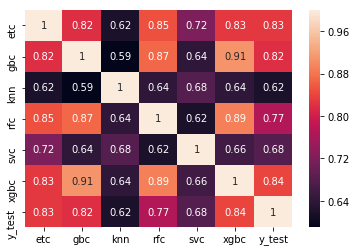

In [49]:
sns.heatmap(predict_df.corr().round(2), annot=True)

Generally, ensembles are known to perform better when uncorrelated predictions are combined together.

In [50]:
logr_X = predict_df.drop('y_test', axis=1)
logr_y = predict_df['y_test']

logr = LogisticRegression()
logr.fit(logr_X, logr_y)

logr.coef_ / 6

array([[ 0.2859821 ,  0.21349771,  0.0970937 ,  0.05678686,  0.20496793,
         0.20153428]])

I grab the coefficients of a logistic regression of the predicted failures and the actual failure to get an idea of the weights to use for my ensemble.

In [51]:
ensemble_pred = (predict_df['rfc'] * 0.2
                 + predict_df['knn'] * 0.2
                 + predict_df['svc'] * 0.1
                 + predict_df['etc'] * 0.05
                 + predict_df['gbc'] * 0.15
                 + predict_df['xgbc'] * 0.3) >= 0.5

In [52]:
printClassificationErrors(y_test, ensemble_pred)

Confusion Matrix:
[[347   4]
 [  6  29]]
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       351
          1       0.88      0.83      0.85        35

avg / total       0.97      0.97      0.97       386

ROC AUC score: 0.9085877085877087
Accuracy Score: 0.9740932642487047


For the classification of devices that failed, there was a final precision score of 0.88 and final recall score of 0.83 on the test set.  This is an improvement over the baseline precision and recall score from the initial random forest.

# Future Improvements
* Gridsearch/Fine-tune models for better accuracy on individual models.
* Stacking ensembles could lead to better scores.
* Use a neural net and additional models for ensembling.